# Fantasy Football ADP

### Name: Jack Savio

### CSCI 3656: Final Project iPYNB Code File

### RESTART KERNEL AND RUN ALL CELLS AT EVERY INSTANCE

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from scipy.interpolate import interp1d
import pandas as pd

This is an IPYNB file that delves into all the decision making and data set manipulation and analysis that delves into ADP evaluation. The CSV files that I have used consist of all pertinent information to be used for draft analysis, such as yards, touchdowns, and other more qualitative variables. It also includes the dependent variable, fantasy football points, that is adjusted based upon the multiple independent variables mentioned above. For starters, I have decided to make a couple of initial alterations to the data sets that will allow for more accurate and concise observations:
1. I have removed all non-FLEX position(QB,D,K) from each section of the data set. Why? These positions in fantasy football drafting work incredibly different in comparison to other players in the league. Since each of these positions typically only have one per team, they are drafted with typically less priority as there are many positions available for a standard 10-12 person league. There ARE differences in drafting depending on player skill, but the variance between their actual fantasy scores and their ADP is so large and acts against the data. This will be explained in detail in the formal paper.
2. Injuries have also been removed from consideration for ADP. When comparing the ADP charts I will produce to the actual real world ones, there will be some players that were injured in the previous season. This would remove them from the previous years and will change the true value of these players. As such, they will not be considered for ADP.
3. There are some other variations that have major impacts on ADP that are strictly non-data base. These variations will be noted in the paper and adjusted in more creative ways.\

From this point, I will be making small comments that describe the thought process behind why each numerical computation technique would be used.

In [28]:
#Initial 2017 Read
df_test = pd.read_csv('2017.csv')
df_test = df_test.dropna(subset=['RushingYds', 'ReceivingYds', 'PassingYds', 'RushingTD', 'ReceivingTD', 'PassingTD', 'FantasyPoints']).copy()

df_test = df_test.sort_values('FantasyPoints', ascending=False).head(100)
print(df_test[['Player', 'FantasyPoints']].head(100))

               Player  FantasyPoints
0         Todd Gurley         383.30
8      Russell Wilson         343.92
1        Le'Veon Bell         341.60
3        Alvin Kamara         312.40
5     DeAndre Hopkins         309.80
..                ...            ...
127      Randall Cobb         157.40
116  Rishard Matthews         156.20
118      Theo Riddick         154.00
109   Giovani Bernard         151.70
104    Chris Thompson         151.40

[100 rows x 2 columns]


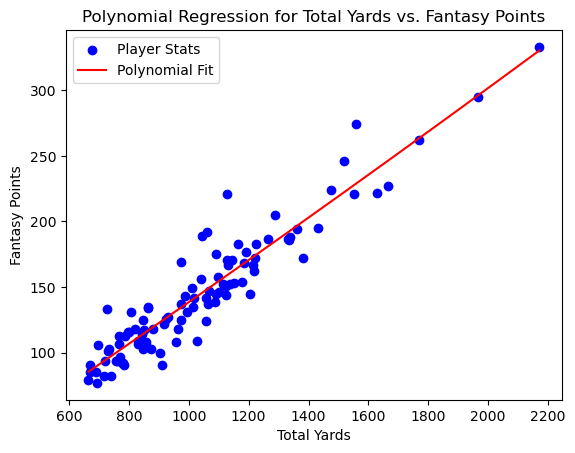

In [2]:
df_2021 = pd.read_csv('2021.csv')
df_2021 = df_2021.dropna(subset=['RushingYds', 'ReceivingYds', 'PassingYds', 'RushingTD', 'ReceivingTD', 'PassingTD', 'FantasyPoints']).copy()


df_2021['TotalYards'] = df_2021['RushingYds'] + df_2021['ReceivingYds']
df_2021['TotalTouchdowns'] = df_2021['RushingTD'] + df_2021['ReceivingTD']
df_2021 = df_2021[df_2021['Pos'] != 'QB']

df_new = df_2021.sort_values('TotalYards', ascending=False).head(100)


x = df_new['TotalYards'].values
y = df_new['FantasyPoints'].values

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x.reshape(-1, 1))

model = LinearRegression()
model.fit(x_poly, y)

x_range = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)

plt.scatter(x, y, color='blue', label='Player Stats')
plt.plot(x_range, y_pred, color='red', label='Polynomial Fit')
plt.xlabel('Total Yards')
plt.ylabel('Fantasy Points')
plt.legend()
plt.title('Polynomial Regression for Total Yards vs. Fantasy Points')
plt.show()

From this polynomial regression of the Fantasy Points vs. Total Yards, it becomes very clear what players are considered as outliers by the fact they are above the curve by a large value. Let's look at these specific players to observe what allows them to score extra fantasy points above the projected level observed by the interpolation.

In [3]:
df_test = df_2021.sort_values('FantasyPoints', ascending=False).head(100)

print(df_test[['Player', 'FantasyPoints', 'TotalYards']])

                 Player  FantasyPoints  TotalYards
0     Jonathan Taylor*+          333.0      2171.0
1         Cooper Kupp*+          295.0      1965.0
4         Austin Ekeler          274.0      1558.0
2        Deebo Samuel*+          262.0      1770.0
10           Joe Mixon*          246.0      1519.0
..                  ...            ...         ...
132     Latavius Murray           94.0       576.0
131  Alexander Mattison           94.0       719.0
130          Mike Davis           94.0       762.0
73         Mike Gesicki           92.0       780.0
134      Pat Freiermuth           92.0       497.0

[100 rows x 3 columns]


In [4]:
y_pred_individual = model.predict(x_poly)
residuals = y - y_pred_individual

threshold = (np.mean(residuals) + np.std(residuals)) / 2
positive_outliers = df_new[residuals > threshold]

print(positive_outliers[['Player', 'FantasyPoints', 'TotalYards', 'Rec', 'TotalTouchdowns']])

                    Player  FantasyPoints  TotalYards    Rec  TotalTouchdowns
4            Austin Ekeler          274.0      1558.0   70.0             20.0
10              Joe Mixon*          246.0      1519.0   42.0             16.0
8           Ja'Marr Chase*          224.0      1476.0   81.0             13.0
21         Ezekiel Elliott          205.0      1289.0   47.0             12.0
20           Stefon Diggs*          183.0      1225.0  103.0             10.0
35   Cordarrelle Patterson          183.0      1166.0   52.0             11.0
24           Mike Williams          171.0      1146.0   76.0              9.0
14           Travis Kelce*          171.0      1128.0   92.0             10.0
15           James Conner*          221.0      1127.0   37.0             18.0
43           Derrick Henry          175.0      1091.0   18.0             10.0
27           Damien Harris          192.0      1061.0   18.0             15.0
16             Mike Evans*          189.0      1045.0   74.0    

So why these players? Most of them are high touchdown players, which leads to variance game to game on scoring. They are slightly more risky as they rely on a more inconsistent variable than from Total Yards. Each of these players are especially notable because their margins are greater than other players around this level. To see in more detail, see the graph below.

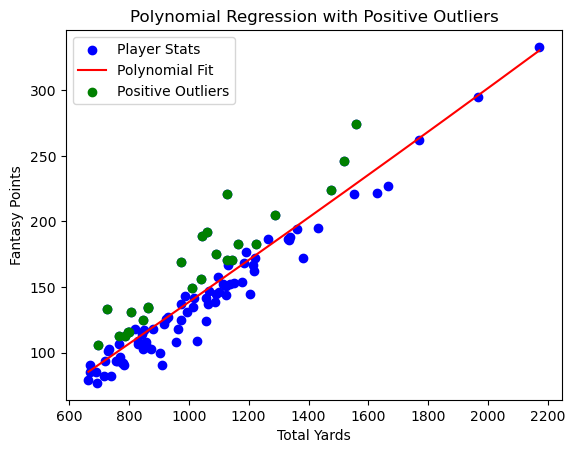

In [5]:
plt.scatter(x, y, color='blue', label='Player Stats')
plt.plot(x_range, y_pred, color='red', label='Polynomial Fit')
plt.scatter(positive_outliers['TotalYards'], positive_outliers['FantasyPoints'], color='green', label='Positive Outliers')
plt.xlabel('Total Yards')
plt.ylabel('Fantasy Points')
plt.legend()
plt.title('Polynomial Regression with Positive Outliers')
plt.show()

This looks like a very good thing for these players, as they are scoring more points than expected for their amount of yards. However, when looking more in depth and bringing in another graph, what this actually means is for the players with these amount of TDs, they are ACTUALLY scoring less than expected for their amount of touchdowns, and vice versa depending on perspective. Since touchdowns have increased variance in comparison to yards, a conclusion can be reached that touchdown reliant players are significantly more inconsistent and should reflect poorly upon their ADP. This could signify that these players are due to decrease their amounts of TDs, or are so reliant on TDs that they score low in weeks where TDs do not occur.

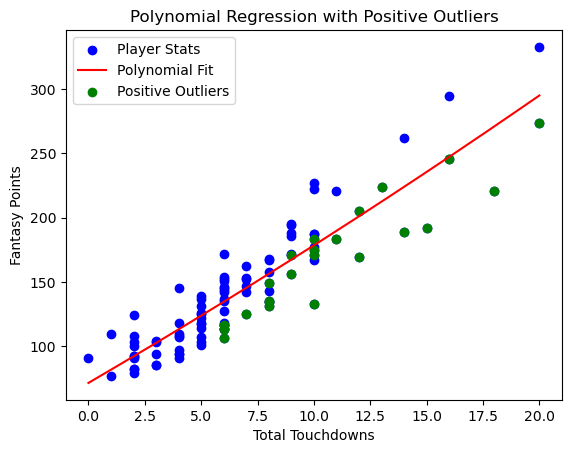

In [6]:
x = df_new['TotalTouchdowns'].values
y = df_new['FantasyPoints'].values

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x.reshape(-1, 1))

model = LinearRegression()
model.fit(x_poly, y)

x_range = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)

plt.scatter(x, y, color='blue', label='Player Stats')
plt.plot(x_range, y_pred, color='red', label='Polynomial Fit')
plt.scatter(positive_outliers['TotalTouchdowns'], positive_outliers['FantasyPoints'], color='green', label='Positive Outliers')
plt.xlabel('Total Touchdowns')
plt.ylabel('Fantasy Points')
plt.legend()
plt.title('Polynomial Regression with Positive Outliers')
plt.show()

After learning some crucial information about what could make outliers occur and why they could be indicators of poor performance in future years, we now want to intepolate our function to allow other players from future years to predict their average draft position.

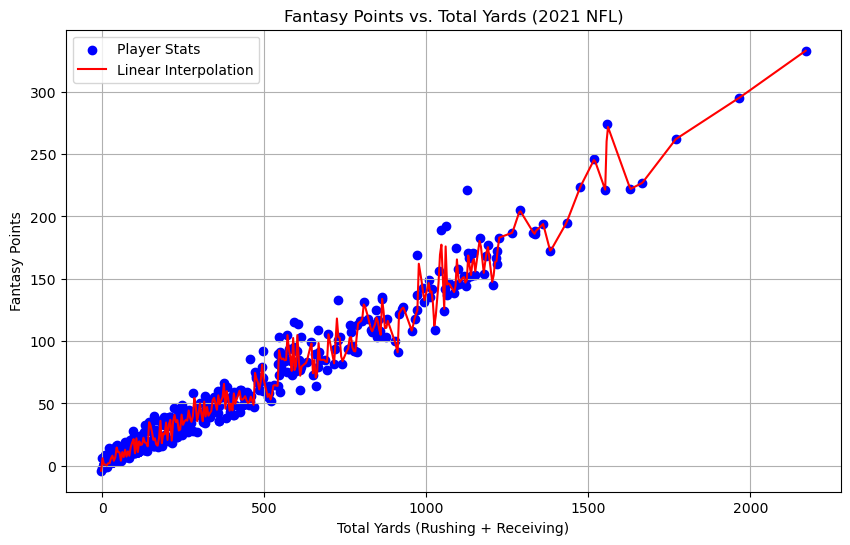

In [7]:
df_2021 = df_2021.sort_values('TotalYards')

interp_func = interp1d(df_2021['TotalYards'], df_2021['FantasyPoints'], kind='linear', fill_value='extrapolate')

x = np.linspace(df_2021['TotalYards'].min(), df_2021['TotalYards'].max(), 500)
y = interp_func(x)

plt.figure(figsize=(10, 6))
plt.scatter(df_2021['TotalYards'], df_2021['FantasyPoints'], color='blue', label='Player Stats')
plt.plot(x, y, color='red', label='Linear Interpolation')
plt.xlabel('Total Yards (Rushing + Receiving)')
plt.ylabel('Fantasy Points')
plt.title('Fantasy Points vs. Total Yards (2021 NFL)')
plt.legend()
plt.grid(True)
plt.show()

This is good information we can use to predict draft position of future players based on previous performance. For the purposes of this test, rookies will be exempt from ADP due to not having previous information on performance. Injuries will be handled by averaging out performance and normalizing it throughout a season by having every player being considered to have their average over sixteen games.

In [21]:
df_2020 = pd.read_csv('2020.csv', index_col=0)
df_2020 = df_2020.dropna(subset=['RushingYds', 'ReceivingYds', 'PassingYds', 'RushingTD', 'ReceivingTD', 'PassingTD', 'FantasyPoints']).copy()
df_2020['TotalYards'] = df_2020['RushingYds'] + df_2020['ReceivingYds']

df_2020['AverageFantasyPoints'] = df_2020['FantasyPoints'] / df_2020['G']
df_2020['FantasyPoints'] = df_2020['AverageFantasyPoints'] * 16

df_2020['AverageYards'] = df_2020['TotalYards'] / df_2020['G']
df_2020['TotalYards'] = df_2020['AverageYards'] * 16

df_2020 = df_2020[df_2020['G'] >= 3]

df_2020['ExpectedFantasyPoints'] = interp_func(df_2020['TotalYards'].values)

df_2020['Residual'] = df_2020['FantasyPoints'] - df_2020['ExpectedFantasyPoints']
df_2020 = df_2020[df_2020['Pos'] != 'QB']

df_2020 = df_2020.sort_values('FantasyPoints', ascending=False)
print(df_2020[['AverageFantasyPoints', 'TotalYards', 'FantasyPoints', 'ExpectedFantasyPoints', 'Residual']].head(100))

                      AverageFantasyPoints   TotalYards  FantasyPoints  \
Player                                                                   
Christian McCaffrey              24.333333  1994.666667     389.333333   
Dalvin Cook                      21.000000  2192.000000     336.000000   
Alvin Kamara                     19.666667  1800.533333     314.666667   
Derrick Henry                    19.625000  2141.000000     314.000000   
Davante Adams                    17.357143  1570.285714     277.714286   
...                                    ...          ...            ...   
Preston Williams                  7.125000   576.000000     114.000000   
John Brown                        7.111111   814.222222     113.777778   
Laviska Shenault Jr.              7.071429   789.714286     113.142857   
Mike Gesicki                      7.066667   749.866667     113.066667   
Mike Williams                     7.066667   807.466667     113.066667   

                      ExpectedFantasy

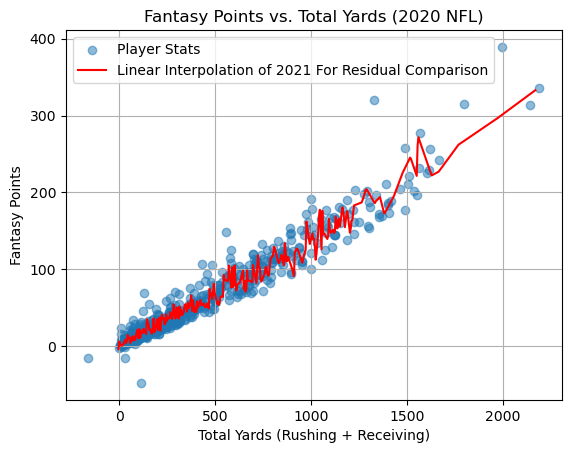

In [9]:
x = np.linspace(df_2021['TotalYards'].min(), df_2021['TotalYards'].max(), 500)
y = interp_func(x)

plt.scatter(df_2020['TotalYards'], df_2020['FantasyPoints'], alpha=0.5, label='Player Stats')
plt.plot(x, y, color='red', label='Linear Interpolation of 2021 For Residual Comparison')
plt.xlabel('Total Yards (Rushing + Receiving)')
plt.ylabel('Fantasy Points')
plt.title('Fantasy Points vs. Total Yards (2020 NFL)')
plt.legend()
plt.grid(True)
plt.show()

Repeat for other years...

In [29]:
df_2019 = pd.read_csv('2019.csv', index_col=0)
df_2019 = df_2019.dropna(subset=['RushingYds', 'ReceivingYds', 'PassingYds', 'RushingTD', 'ReceivingTD', 'PassingTD', 'FantasyPoints']).copy()
df_2019['TotalYards'] = df_2019['RushingYds'] + df_2019['ReceivingYds']
df_2019['AverageFantasyPoints'] = df_2019['FantasyPoints'] / df_2019['G']
df_2019['FantasyPoints'] = df_2019['AverageFantasyPoints'] * 16

df_2019['AverageYards'] = df_2019['TotalYards'] / df_2019['G']
df_2019['TotalYards'] = df_2019['AverageYards'] * 16

df_2019 = df_2019[df_2019['G'] >= 3]

df_2019['ExpectedFantasyPoints'] = interp_func(df_2019['TotalYards'].values)

df_2019['Residual'] = df_2019['FantasyPoints'] - df_2019['ExpectedFantasyPoints']
df_2019 = df_2019[df_2019['Pos'] != 'QB']

print("2019 Fantasy Points")
print(df_2019[['Player', 'TotalYards', 'FantasyPoints', 'ExpectedFantasyPoints', 'Residual']].head(100))


df_2018 = pd.read_csv('2018.csv', index_col=0)
df_2018 = df_2018.dropna(subset=['RushingYds', 'ReceivingYds', 'PassingYds', 'RushingTD', 'ReceivingTD', 'PassingTD', 'FantasyPoints']).copy()
df_2018['TotalYards'] = df_2018['RushingYds'] + df_2018['ReceivingYds']
df_2018['AverageFantasyPoints'] = df_2018['FantasyPoints'] / df_2018['G']
df_2018['FantasyPoints'] = df_2018['AverageFantasyPoints'] * 16

df_2018['AverageYards'] = df_2018['TotalYards'] / df_2018['G']
df_2018['TotalYards'] = df_2018['AverageYards'] * 16

df_2018 = df_2018[df_2018['G'] >= 3]

df_2018['ExpectedFantasyPoints'] = interp_func(df_2018['TotalYards'].values)

df_2018['Residual'] = df_2018['FantasyPoints'] - df_2018['ExpectedFantasyPoints']
df_2018 = df_2018[df_2018['Pos'] != 'QB']

print("2018 Fantasy Points")
print(df_2018[['Player', 'TotalYards', 'FantasyPoints', 'ExpectedFantasyPoints', 'Residual']].head(100))

df_2017 = pd.read_csv('2017.csv', index_col=0)
df_2017 = df_2017.dropna(subset=['RushingYds', 'ReceivingYds', 'PassingYds', 'RushingTD', 'ReceivingTD', 'PassingTD', 'FantasyPoints']).copy()
df_2017['TotalYards'] = df_2017['RushingYds'] + df_2017['ReceivingYds']
df_2017['AverageFantasyPoints'] = df_2017['FantasyPoints'] / df_2017['G']
df_2017['FantasyPoints'] = df_2017['AverageFantasyPoints'] * 16

df_2017['AverageYards'] = df_2017['TotalYards'] / df_2017['G']
df_2017['TotalYards'] = df_2017['AverageYards'] * 16

df_2017 = df_2017[df_2017['G'] >= 3]

df_2017['ExpectedFantasyPoints'] = interp_func(df_2017['TotalYards'].values)

df_2017['Residual'] = df_2017['FantasyPoints'] - df_2017['ExpectedFantasyPoints']
df_2017 = df_2017[df_2017['Pos'] != 'QB']

print("2017 Fantasy Points")
df_2017 = df_2017.sort_values('FantasyPoints', ascending=False)
print(df_2017[['Player',  'TotalYards', 'FantasyPoints', 'ExpectedFantasyPoints', 'Residual']].head(100))

2019 Fantasy Points
                         Player   TotalYards  FantasyPoints  \
Unnamed: 0                                                    
0           Christian McCaffrey  2392.000000     469.200000   
2                 Derrick Henry  1862.400000     314.240000   
3                   Aaron Jones  1558.000000     314.800000   
4               Ezekiel Elliott  1777.000000     311.700000   
5                   Dalvin Cook  1890.285714     334.171429   
...                         ...          ...            ...   
126             Tyrell Williams   744.000000     163.542857   
127              Marquise Brown   667.428571     167.314286   
128                Randall Cobb   894.933333     165.226667   
129              Christian Kirk   987.076923     204.553846   
130               Royce Freeman   752.000000     142.200000   

            ExpectedFantasyPoints   Residual  
Unnamed: 0                                    
0                      373.766990  95.433010  
2                  

To get the estimated draft order for each player from here, we want to manipulate the residual and their normal fantasy points to get a number for their draft order. As we determined above that having a high residual is actually a negative indicator for future fantasy football performance (as they are playing above the estimated margins, which indicates high touchdowns and low yardage). For this purpose, we will subtract or add a percentage of the residual from their previous year of fantasy points in order to draw conclusions about where they should be drafted. The most logical number to manipulate is one standard deviation of the residual. This adjustment is because we do not want to completely void the outperforming of the estimation, but we want to adjust to factor in the possibility of inconsistency.

In [11]:
df_2020['ADPFantasyPoints'] = df_2020['FantasyPoints'] - np.std(df_2020['Residual'])
df_2020 = df_2020.sort_values('ADPFantasyPoints', ascending=False).head(100)

df_2019['ADPFantasyPoints'] = df_2019['FantasyPoints'] - np.std(df_2019['Residual'])
df_2019 = df_2019.sort_values('ADPFantasyPoints', ascending=False).head(100)

df_2018['ADPFantasyPoints'] = df_2018['FantasyPoints'] - np.std(df_2018['Residual'])
df_2018 = df_2018.sort_values('ADPFantasyPoints', ascending=False).head(100)

df_2017['ADPFantasyPoints'] = df_2017['FantasyPoints'] - np.std(df_2017['Residual'])
df_2017 = df_2017.sort_values('ADPFantasyPoints', ascending=False).head(100)

print(df_2020[['FantasyPoints', 'ADPFantasyPoints']])

                     FantasyPoints  ADPFantasyPoints
Player                                              
Christian McCaffrey     389.333333        371.359954
Dalvin Cook             336.000000        318.026621
Antonio Williams        320.000000        302.026621
Alvin Kamara            314.666667        296.693288
Derrick Henry           314.000000        296.026621
...                            ...               ...
T.Y. Hilton             115.200000         97.226621
Chase Edmonds           115.000000         97.026621
Preston Williams        114.000000         96.026621
Michael Gallup          114.000000         96.026621
John Brown              113.777778         95.804399

[100 rows x 2 columns]


To advance this further, we can use other variables present when true professionals are considering ADP: Positional Value and Age indicators. For positional value, we can simply look at the make up for each position in the top fifty players and adjust based on this. For instance, if the top fifty is made up of 35 RBs, they have less value than the 10 WRs in the top fifty of positions in a standard league. Professionals also consider age as a factor. This factor is a bit more complicated, so I will be repeating some of the previous steps we made, but considering age in comparison to fantasy points.

In [12]:
df_2020 = df_2020.sort_values('Age', ascending=True).head(100)

print(df_2020[['Age', 'FantasyPoints', 'ADPFantasyPoints']])

                       Age  FantasyPoints  ADPFantasyPoints
Player                                                     
D'Andre Swift           21     177.230769        159.257390
CeeDee Lamb             21     144.000000        126.026621
Clyde Edwards-Helaire   21     172.307692        154.334313
Justin Jefferson        21     186.000000        168.026621
Tee Higgins             21     128.000000        110.026621
...                    ...            ...               ...
T.Y. Hilton             31     115.200000         97.226621
Travis Kelce            31     221.866667        203.893288
Cole Beasley            31     134.400000        116.426621
Antonio Brown           32     144.000000        126.026621
Emmanuel Sanders        33     118.857143        100.883764

[100 rows x 3 columns]


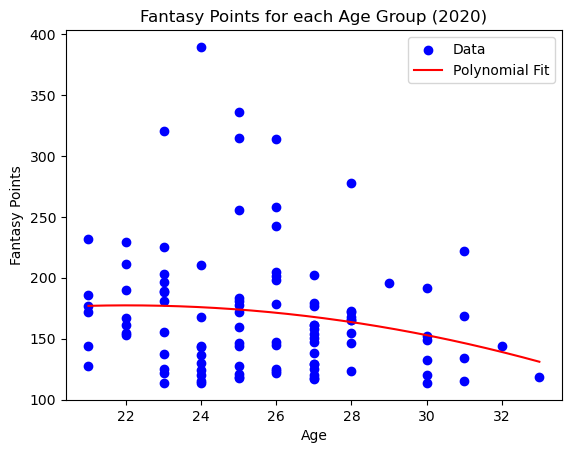

In [13]:
x = df_2020['Age'].values
y = df_2020['FantasyPoints'].values

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x.reshape(-1, 1))

model = LinearRegression()
model.fit(x_poly, y)

x_range = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)

plt.scatter(x, y, color='blue', label='Data')
plt.plot(x_range, y_pred, color='red', label='Polynomial Fit')
plt.xlabel('Age')
plt.ylabel('Fantasy Points')
plt.legend()
plt.title('Fantasy Points for each Age Group (2020)')
plt.show()

By this polynomial regression, it is likely that after the age of twenty six - the player is likely to regress by a small margin, and before the age of twenty five - the player is likely to improve by a small margin. Lets repeat for each year, and see if this pattern is consistent between each year.

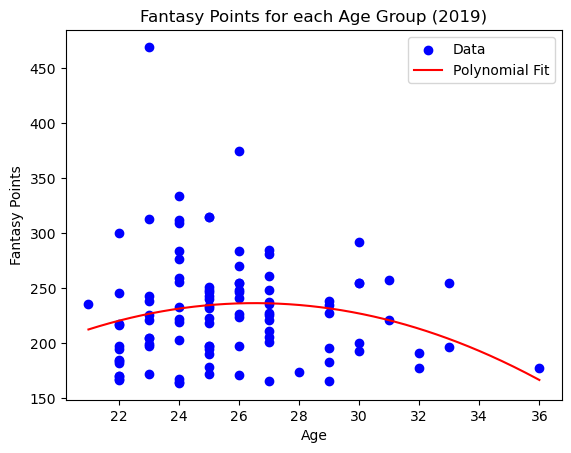

In [14]:
df_2019 = df_2019.sort_values('Age', ascending=False).head(100)

x = df_2019['Age'].values
y = df_2019['FantasyPoints'].values

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x.reshape(-1, 1))

model = LinearRegression()
model.fit(x_poly, y)

x_range = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)

plt.scatter(x, y, color='blue', label='Data')
plt.plot(x_range, y_pred, color='red', label='Polynomial Fit')
plt.xlabel('Age')
plt.ylabel('Fantasy Points')
plt.legend()
plt.title('Fantasy Points for each Age Group (2019)')
plt.show()

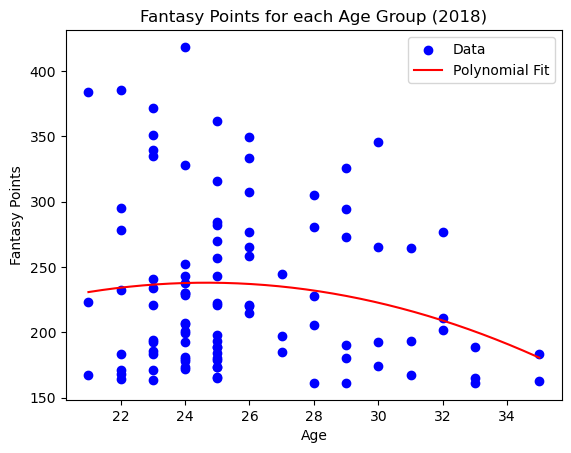

In [15]:
df_2018 = df_2018.sort_values('Age', ascending=False).head(100)

x = df_2018['Age'].values
y = df_2018['FantasyPoints'].values

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x.reshape(-1, 1))

model = LinearRegression()
model.fit(x_poly, y)

x_range = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)

plt.scatter(x, y, color='blue', label='Data')
plt.plot(x_range, y_pred, color='red', label='Polynomial Fit')
plt.xlabel('Age')
plt.ylabel('Fantasy Points')
plt.legend()
plt.title('Fantasy Points for each Age Group (2018)')
plt.show()

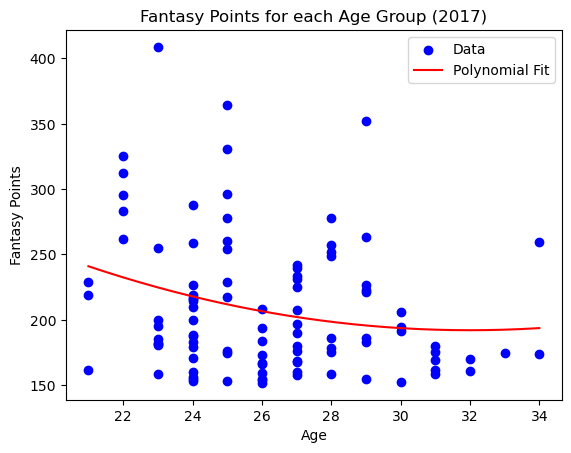

In [16]:
df_2017 = df_2017.sort_values('Age', ascending=False).head(100)

x = df_2017['Age'].values
y = df_2017['FantasyPoints'].values

poly = PolynomialFeatures(degree=2)
x_poly = poly.fit_transform(x.reshape(-1, 1))

model = LinearRegression()
model.fit(x_poly, y)

x_range = np.linspace(x.min(), x.max(), 300).reshape(-1, 1)
x_range_poly = poly.transform(x_range)
y_pred = model.predict(x_range_poly)

plt.scatter(x, y, color='blue', label='Data')
plt.plot(x_range, y_pred, color='red', label='Polynomial Fit')
plt.xlabel('Age')
plt.ylabel('Fantasy Points')
plt.legend()
plt.title('Fantasy Points for each Age Group (2017)')
plt.show()

As we look at more years, this guess seems to be incorrect. However, over multiple years, it is clear that age is a negative indicator for performance. As age increases, fantasy point scores is likely to decrease respectively. Since this appears to be a very minimal amount, we will simply use exponential decay after the average age that players start to regress iin performance across each year. Since this is a very small input, we will have a very low decay value initially.

In [17]:
decay_rate = 0.01
df_2020['ADPFantasyPoints'] = df_2020['ADPFantasyPoints'] * np.exp(-decay_rate * (df_2020['Age'] - 24))

df_2020 = df_2020.sort_values('ADPFantasyPoints', ascending=False).head(100)

df_2019['ADPFantasyPoints'] = df_2019['ADPFantasyPoints'] * np.exp(-decay_rate * (df_2019['Age'] - 24))

df_2019 = df_2019.sort_values('ADPFantasyPoints', ascending=False).head(100)

df_2018['ADPFantasyPoints'] = df_2018['ADPFantasyPoints'] * np.exp(-decay_rate * (df_2018['Age'] - 24))

df_2018 = df_2018.sort_values('ADPFantasyPoints', ascending=False).head(100)

df_2017['ADPFantasyPoints'] = df_2017['ADPFantasyPoints'] * np.exp(-decay_rate * (df_2017['Age'] - 24))

df_2017 = df_2017.sort_values('ADPFantasyPoints', ascending=False).head(100)
print(df_2020[['Age', 'FantasyPoints', 'ADPFantasyPoints']])

                     Age  FantasyPoints  ADPFantasyPoints
Player                                                   
Christian McCaffrey   24     389.333333        371.359954
Dalvin Cook           25     336.000000        314.862203
Antonio Williams      23     320.000000        305.062039
Alvin Kamara          25     314.666667        293.741140
Derrick Henry         26     314.000000        290.164901
...                  ...            ...               ...
Tim Patrick           27     117.333333         96.423424
Michael Gallup        24     114.000000         96.026621
Emmanuel Sanders      33     118.857143         92.200818
T.Y. Hilton           31     115.200000         90.653500
John Brown            30     113.777778         90.225185

[100 rows x 3 columns]


Now for position, we will organize by number in the top hundred for positions.

In [18]:
position_counts = df_2020['Pos'].value_counts()

relative_representation = (position_counts / 100).sort_values(ascending=False)

positional_value = 1 / (relative_representation / relative_representation.mean())

min_val = positional_value.min()
max_val = positional_value.max()

scaled = (positional_value - min_val) / (max_val - min_val)
positional_value = 0.95 + scaled * (1.00 - 0.95)

df_2020['PositionValue'] = df_2020['Pos'].map(positional_value)
df_2020['ADPFantasyPoints'] = df_2020['ADPFantasyPoints'] * df_2020['PositionValue']
df_2020 = df_2020.sort_values('ADPFantasyPoints', ascending=False).head(100)
print(df_2020[['Age', 'ADPFantasyPoints']].head(25))

                     Age  ADPFantasyPoints
Player                                    
Christian McCaffrey   24        353.252558
Dalvin Cook           25        299.509620
Antonio Williams      23        290.187309
Alvin Kamara          25        279.418413
Derrick Henry         26        276.016550
Davante Adams         28        237.078504
Nick Chubb            25        224.167595
Tyreek Hill           26        223.634245
Jonathan Taylor       21        209.268232
Aaron Jones           26        209.149828
James Robinson        22        205.485369
David Montgomery      23        198.975321
Travis Kelce          31        190.108841
Josh Jacobs           22        187.518057
Joe Mixon             24        183.297623
A.J. Brown            23        177.953096
Calvin Ridley         26        173.970846
Myles Gaskin          23        171.816695
Chris Carson          26        170.965645
Stefon Diggs          27        169.658422
Will Fuller           26        167.469455
Antonio Gib

Repeat for other years once again...

In [19]:
position_counts = df_2019['Pos'].value_counts()

relative_representation = (position_counts / 100).sort_values(ascending=False)


positional_value = 1 / (relative_representation / relative_representation.mean())

min_val = positional_value.min()
max_val = positional_value.max()

scaled = (positional_value - min_val) / (max_val - min_val)
positional_value = 0.95 + scaled * (1.00 - 0.95)

df_2019['PositionValue'] = df_2019['Pos'].map(positional_value)
df_2019['ADPFantasyPoints'] = df_2019['ADPFantasyPoints'] * df_2019['PositionValue']
df_2019 = df_2019.sort_values('ADPFantasyPoints', ascending=False).head(100)
print(df_2019[['Player', 'ADPFantasyPoints']].head(25))

position_counts = df_2018['Pos'].value_counts()

relative_representation = (position_counts / 100).sort_values(ascending=False)


positional_value = 1 / (relative_representation / relative_representation.mean())

min_val = positional_value.min()
max_val = positional_value.max()

scaled = (positional_value - min_val) / (max_val - min_val)
positional_value = 0.95 + scaled * (1.00 - 0.95)

df_2018['PositionValue'] = df_2018['Pos'].map(positional_value)
df_2018['ADPFantasyPoints'] = df_2018['ADPFantasyPoints'] * df_2018['PositionValue']
df_2018 = df_2018.sort_values('ADPFantasyPoints', ascending=False).head(100)
print(df_2018[['Player', 'ADPFantasyPoints']].head(25))

position_counts = df_2017['Pos'].value_counts()

relative_representation = (position_counts / 100).sort_values(ascending=False)


positional_value = 1 / (relative_representation / relative_representation.mean())

min_val = positional_value.min()
max_val = positional_value.max()

scaled = (positional_value - min_val) / (max_val - min_val)
positional_value = 0.95 + scaled * (1.00 - 0.95)

df_2017['PositionValue'] = df_2017['Pos'].map(positional_value)
df_2017['ADPFantasyPoints'] = df_2017['ADPFantasyPoints'] * df_2017['PositionValue']
df_2017 = df_2017.sort_values('ADPFantasyPoints', ascending=False).head(100)
print(df_2017[['Player', 'ADPFantasyPoints']].head(25))

                         Player  ADPFantasyPoints
Unnamed: 0                                       
0           Christian McCaffrey        423.553826
6                Michael Thomas        320.605843
5                   Dalvin Cook        290.327917
14                 Chris Godwin        271.508349
3                   Aaron Jones        269.115060
4               Ezekiel Elliott        268.857852
2                 Derrick Henry        268.585338
9                 Austin Ekeler        266.278169
20               Saquon Barkley        263.304577
40                 Alvin Kamara        242.414048
32                   Mike Evans        236.182839
28            Leonard Fournette        235.411140
26                  Julio Jones        234.468458
34              DeAndre Hopkins        234.174696
73                Davante Adams        231.062283
25                  Cooper Kupp        223.669095
15                George Kittle        219.547931
364                   Wes Hills        218.697338


We are complete! These will be used and described in detail in the formal paper. We have an estimated ADPFantasyPoints for each player and can form and compare our ADP versus the actual ADP produced in the real world.